# Clustering the synthetic response spectra using K-means and DBSCAN algorithms  and  t-SNE for dimensionality reduction
### Leonardo Alvarado (joleonar@gmail.com)

The **response spectrum** is an important concept in earthquake engineering, is a practical means of charecterizing ground motion and their effects on the structures. The response spectrumm provide the peak response (displacemente, velocity or acceleration) of all possible linear single degree of freedom systems (SDF) to a particular component of the ground motion (Chopra, 1995) (Figure 1).

In this notebook We will use the **Response Spectra Ratio (RSR)** obtained from synthetic seismograms at 879 sites distributed along 9 profiles. These RSR will be grouped in clusters. We will use two methods: **[K-means](https://en.wikipedia.org/wiki/K-means_clustering)** and **[DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)** algorithms to find the cluster but before apply the clustering algoritmh we will reduce the dimensionality of the curves using the **[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)** algorithm.



<img src="espectros.png" alt="Imagen espectro" width="80%"/>



In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

### 1. Loading data, plotting and smoothing time series by moving average technique

The complete set of data is a 2 dimensional array $(879 x 50)$ where 850 is the number of curves (spectra) and 50 is the number of point of each curves. The frequebcis

In [2]:
#Loading data
data=np.loadtxt('./Espectros/Data_T9P.txt')  #Spectra amplitudes 
x=np.loadtxt('./Espectros/frecuencias.txt')  #Frequencies (between 0.0)

print("data is an array of " + str(data.shape[0]) +' x '+ str(data.shape[1]) )
data

data is an array of 879 x 50


array([[0.253032, 0.257043, 0.26063 , ..., 0.523256, 0.473136, 0.510308],
       [0.220991, 0.224191, 0.227331, ..., 0.460993, 0.461681, 0.487554],
       [0.243125, 0.246808, 0.250258, ..., 0.448425, 0.447245, 0.493451],
       ...,
       [1.01752 , 1.01039 , 1.00523 , ..., 1.01846 , 1.00781 , 0.986805],
       [0.969759, 0.973517, 0.977345, ..., 1.02436 , 1.00337 , 0.969045],
       [0.992353, 0.989656, 0.989359, ..., 1.01439 , 0.983373, 0.940902]])

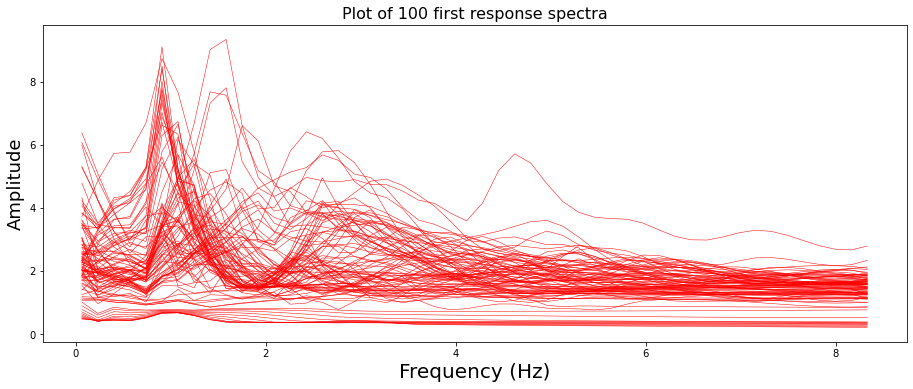

In [3]:
#Plotting  the first 100 curves
plt.plot(x,data[1:100].transpose(), color='r', lw=0.5)                    # plot the first 3 columns
plt.xlabel('Frequency (Hz)',fontsize='20'); plt.ylabel('Amplitude', fontsize='18') # add labels to axes
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2) # set the plot scale
plt.title('Plot of 100 first response spectra',fontsize='16');

#### Smoothing curves
The signal is smoothing  by the moving average method a well known technique. An example of 3-sample  moving average is given by

$$
x_j^n=\frac{x_{j-1}+x_j+x_{j+1}}{3}
$$

In [4]:
# Moving average for smoothing time series
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [5]:
X_smooth = smooth(data[0,:],5) #Smoothing the first curve
X_smooth=X_smooth[None,:]  # Define a array for smoothed curves

for fila in data[1:]:
    A = smooth(fila,5)
    A=A[None,:]
    X_smooth = np.concatenate([X_smooth,A],axis=0)

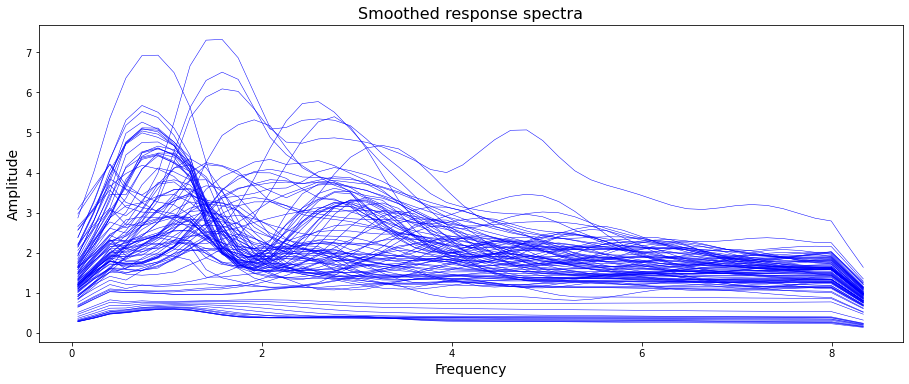

In [6]:
#Plot the curves smoothed
plt.plot(x,X_smooth[0:100].transpose(), color='b', lw=0.5)  # plot the first 100 curves
plt.xlabel('Frequency', fontsize=14); plt.ylabel('Amplitude', fontsize=14) # add labels to axes
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2) # set the plot scale
plt.title("Smoothed response spectra", fontsize=16);

### 2. Apply t-SNE algorithm 
We apply the t-SNE algotithm to reduce the dimensionality of the curves from 50-dim to 2-dim. The we apply  clustering algoithms: **K-means and DBSCAN** for grouping the 2-dim data.


In [7]:
import matplotlib
matplotlib.rcParams['figure.dpi']=100 # highres display

# for updating display 
# (very simple animation)
from IPython.display import clear_output

In [8]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

# note by FM: For this notebook, the MNIST example was dropped

import numpy as np

def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, 
         do_animation=False, animation_skip_steps=10, max_iter = 1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
        
        Added by F. Marquardt: do_animation==True will give you a graphical animation of
        the progress, use animation_skip_steps to control how often this will
        be plotted; max_iter controls the total number of gradient descent steps
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    if do_animation: # added by FM
        costs=np.zeros(max_iter) # to store the cost values
        
    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if not do_animation: # added by FM: do not print if we are animating!
            # Compute current value of cost function
            if (iter + 1) % 10 == 0:
                C = np.sum(P * np.log(P / Q))
                print("Iteration %d: error is %f" % (iter + 1, C), end="           \r") # modified to overwrite line

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.
            
        if do_animation:  # added by FM
            C = np.sum(P * np.log(P / Q)) # compute for every step, to store it in 'costs'
            costs[iter]=C
            if iter % animation_skip_steps==0:
                clear_output(wait=True)
                fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(10,5))
                ax[0].plot(costs)
                ax[1].scatter(Y[:,0],Y[:,1],color="orange")
                plt.show()

    # Return solution
    return Y

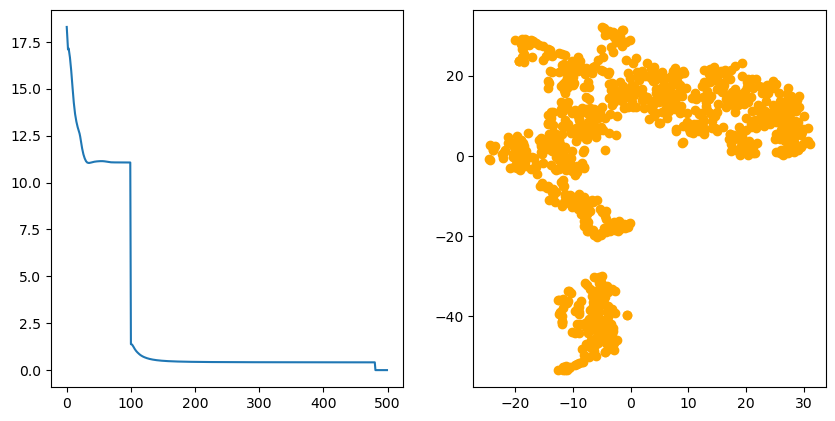

<Figure size 800x800 with 0 Axes>

In [9]:

Y=tsne(X_smooth, no_dims=2, initial_dims=50, perplexity=40.0, 
       do_animation=True, animation_skip_steps=20, max_iter=500)

# plot the points according to the t-SNE projection into 2D space
# color them according to the cluster they belong to!
plt.figure(figsize=(8,8))
#for j in range(n_clusters):
#    Y0=Y[j*N_cluster_points:(j+1)*N_cluster_points,0]
#   Y1=Y[j*N_cluster_points:(j+1)*N_cluster_points,1]    
#    plt.scatter(Y0,Y1)
plt.show();

### 3. Clustering of 2-dim response spectra using K-Means algorithm
We apply the K-means algorithm to cluster the 2-dim data. To find the optimal number of clusters in the data we use the **[Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering))**

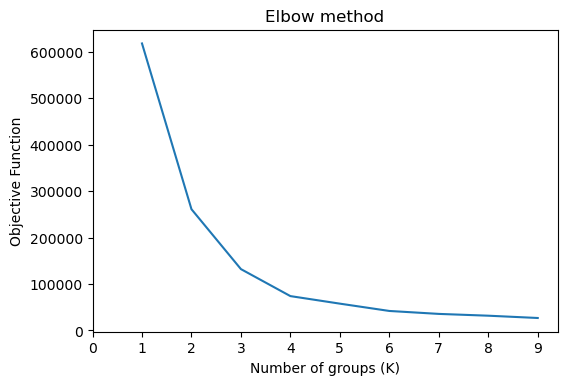

In [10]:
from sklearn.cluster import KMeans
#import matplotlib.cm as cm

## Elbow method
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]
score=  [ -x for x in score]

plt.plot(Nc,score)
plt.xlabel('Number of groups (K)')
plt.ylabel('Objective Function')
plt.title('Elbow method')

plt.xticks(np.arange(0, 10, step=1))
#plt.savefig('FuncObjetivo_Tra_Euclid',dpi=200)
plt.show()


#### Appling the K-means algorithm
From elbow method we choose **K=4** and deploy the result in 2-dim. Stars represent the centroids of each cluster.

After find the groups we plot the different curves in the original dimension and finally the location of ecah group along the profiles

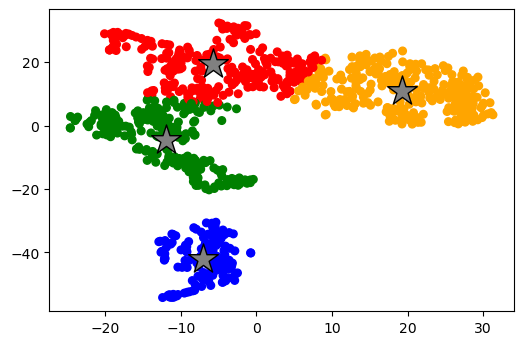

In [11]:
# Predicting the clusters
K=4; # obtained from elbow method
# Y is the output of the t-SNE (2-dim)
kmeans = KMeans(n_clusters=K).fit(Y)

C = kmeans.cluster_centers_  # Centroids
labels = kmeans.predict(Y)   # labels of each

color_c=['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','yellow']
#colores=color_c[0:K]
asignar=[]
for row in labels:
    asignar.append(color_c[row])

plt.scatter(Y[:, 0], Y[:, 1], c=asignar,s=30) # plot data
plt.scatter(C[:, 0], C[:, 1], marker='*', c='gray', s=500, edgecolor='k'); # plot centroids

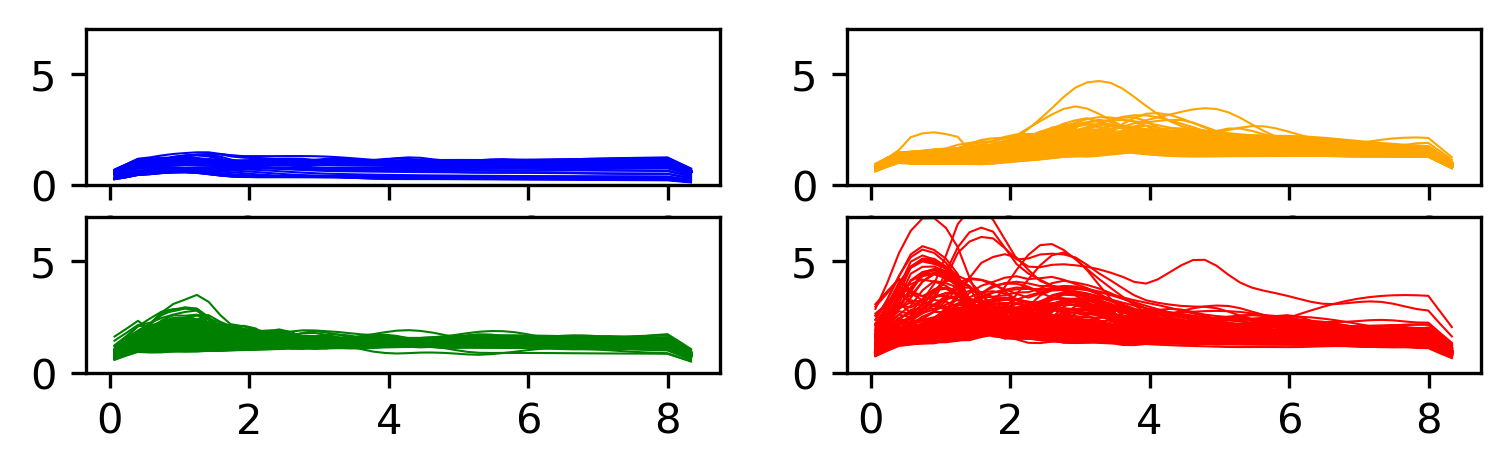

In [12]:
# Plotting the curves
matplotlib.rcParams['figure.dpi']=300
#color_c=['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','yellow']
for grupo in range(0,K):
    G = X_smooth[labels==grupo]
    plt.subplot(5,2,grupo+1)
    plt.plot(x,G.transpose(),color_c[grupo],linewidth=0.5)
    plt.ylim([0,7])


plt.show();

In [13]:
# Function for plotting the groups obtained by clustering technique along the profiles
def mapa_grupos(clusters,region,titulo,salida=''):
    """
        Function for mapping the profiles 
        cluster: List of groups of each curves obtained from clustering algoritm
        region: for plot curves regions, etc value: microzonas
        salida: name of the output image
    """
    matplotlib.rcParams['figure.dpi']=300 
    color=['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','yellow']
    dat_map = './datos_mapa/' # path of data for mapping
    
    if region == 'microzonas':
        # Load las Microzonas regions
        MZ2  = np.loadtxt(dat_map+'Mzona2.txt',skiprows=2)
        MZ3a = np.loadtxt(dat_map+'Mzona3a.txt',skiprows=2)
        MZ3b = np.loadtxt(dat_map+'Mzona3b.txt',skiprows=2)
        MZ3c = np.loadtxt(dat_map+'Mzona3c.txt',skiprows=2)
        MZ4a = np.loadtxt(dat_map+'Mzona4a.txt',skiprows=2)
        MZ4b = np.loadtxt(dat_map+'Mzona4b.txt',skiprows=2)
        MZ5a = np.loadtxt(dat_map+'Mzona5a.txt',skiprows=2)
        MZ5b = np.loadtxt(dat_map+'Mzona5b.txt',skiprows=2)
        MZ6  = np.loadtxt(dat_map+'Mzona6.txt',skiprows=2)

        # Load curves of sediment thick
        Sid2  = np.loadtxt(dat_map+'espesor_id2.txt')
        Sid3  = np.loadtxt(dat_map+'espesor_id3.txt')
        S100  = np.loadtxt(dat_map+'espesor100m.txt',skiprows=1)
        S100W = np.loadtxt(dat_map+'espesor100mOeste.txt',skiprows=1)
        S200  = np.loadtxt(dat_map+'espesor200m.txt',skiprows=1)
        S300  = np.loadtxt(dat_map+'espesor300m.txt',skiprows=1)

       
        # Plot microzones 
        plt.fill(MZ2[:,0],MZ2[:,1],'b',linewidth=0.5,alpha=0.1)
        plt.fill(MZ3a[:,0],MZ3a[:,1],'g',linewidth=0.5,alpha=0.1)
        plt.fill(MZ3b[:,0],MZ3b[:,1],'g',linewidth=0.5,alpha=0.1)
        plt.fill(MZ3c[:,0],MZ3c[:,1],'g',linewidth=0.5,alpha=0.1)
        plt.fill(MZ4a[:,0],MZ4a[:,1],'orange',linewidth=0.5,alpha=0.1)
        plt.fill(MZ4b[:,0],MZ4b[:,1],'orange',linewidth=0.5,alpha=0.1)
        plt.fill(MZ5a[:,0],MZ5a[:,1],'r',linewidth=0.5,alpha=0.1)
        plt.fill(MZ5b[:,0],MZ5b[:,1],'r',linewidth=0.5,alpha=0.1)
        plt.fill(MZ6[:,0],MZ6[:,1],'gray',linewidth=0.5,alpha=0.1)

        # Plot thick sediments curves
        plt.fill(Sid2[:,0],Sid2[:,1],edgecolor='k',linewidth=0.5,fill =False)
        plt.fill(Sid3[:,0],Sid3[:,1],edgecolor='k',linewidth=0.5,fill = False)
        plt.fill(S100[:,0],S100[:,1],edgecolor='k',linewidth=0.5,fill =False)
        plt.fill(S100W[:,0],S100W[:,1],edgecolor='k',linewidth=0.5,fill = False)
        plt.fill(S200[:,0],S200[:,1],edgecolor='k',linewidth=0.5,fill = False)
        plt.fill(S300[:,0],S300[:,1],edgecolor='k',linewidth=0.5,fill = False)
       
        plt.text(460700, 1108400, '60m',fontsize=7, rotation=-10)
        plt.text(458800, 1113800, '60m',fontsize=7, rotation=20)
        plt.text(458800, 1110800, '100m',fontsize=7, rotation=90)
        plt.text(470500, 1106100, '60m',fontsize=7, rotation=20)
        plt.text(473000, 1113200, '100m',fontsize=7, rotation=40)
        plt.text(476000, 1113600, '200m',fontsize=7, rotation=0)
        plt.text(477000, 1113000, '300m',fontsize=7, rotation=10)
     
    # Ploting the groups along profiles
    K = len(set(clusters))
    #Receivers receptor along the profiles
    PA = np.loadtxt(dat_map+'coordenadas_p1_9.txt',skiprows=1)
    per_c=PA[:,[2,3]]
    
    for grupo in range(K):
        ind=clusters==grupo
        plt.scatter(per_c[ind, 0], per_c[ind, 1], s=5,color=color[grupo], edgecolors='None')

        
    plt.xlim([450000,480000]); plt.ylim([1101000,1121000])
    plt.title(titulo)
    if salida:
        plt.savefig(salida+'.png',dpi=500) 
    plt.show()

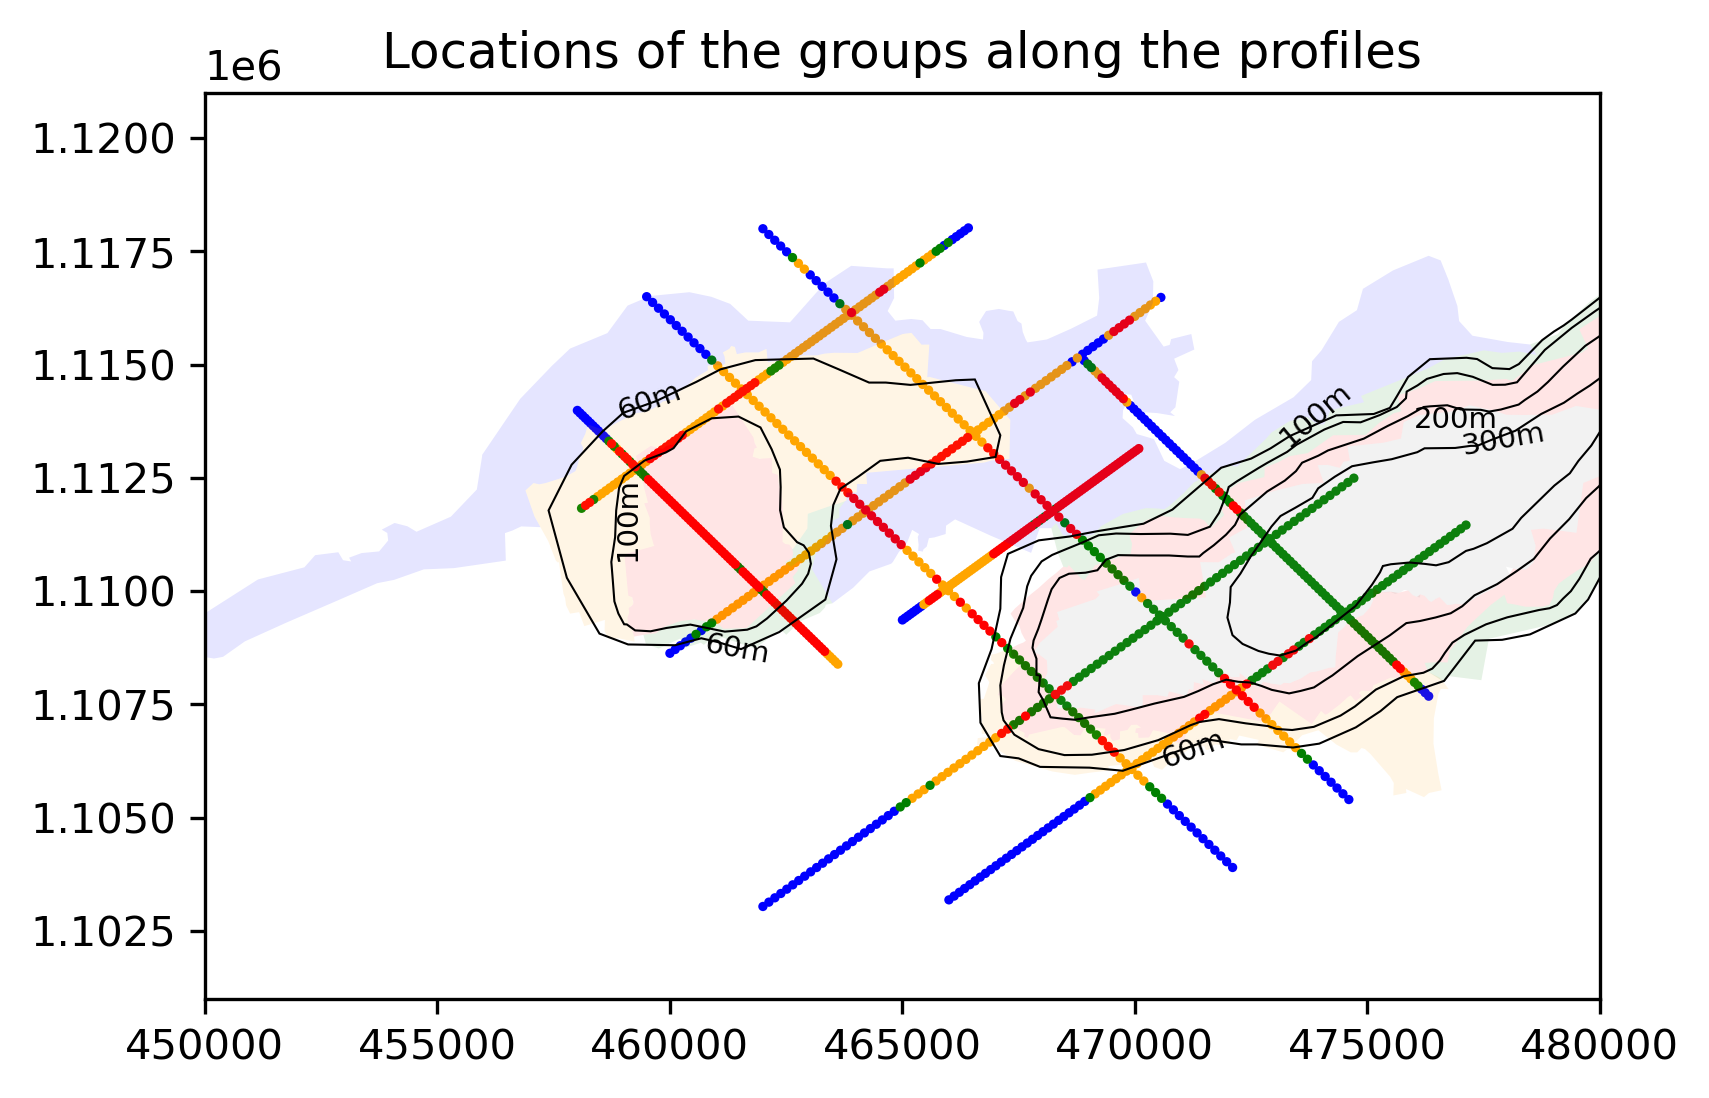

In [14]:
mapa_grupos(labels,'microzonas','Locations of the groups along the profiles')

### 5. DBSCAN ALGORITHM

We also apply the **Density-based spatial clustering [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)**

In [16]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
#from Plot_espectros_mapas import *

X=Y
## DBSCAN con Distancia Euclidea
db = DBSCAN(eps=2.0, min_samples=5,metric='euclidean').fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: %d' % n_clusters)


Number of clusters: 8


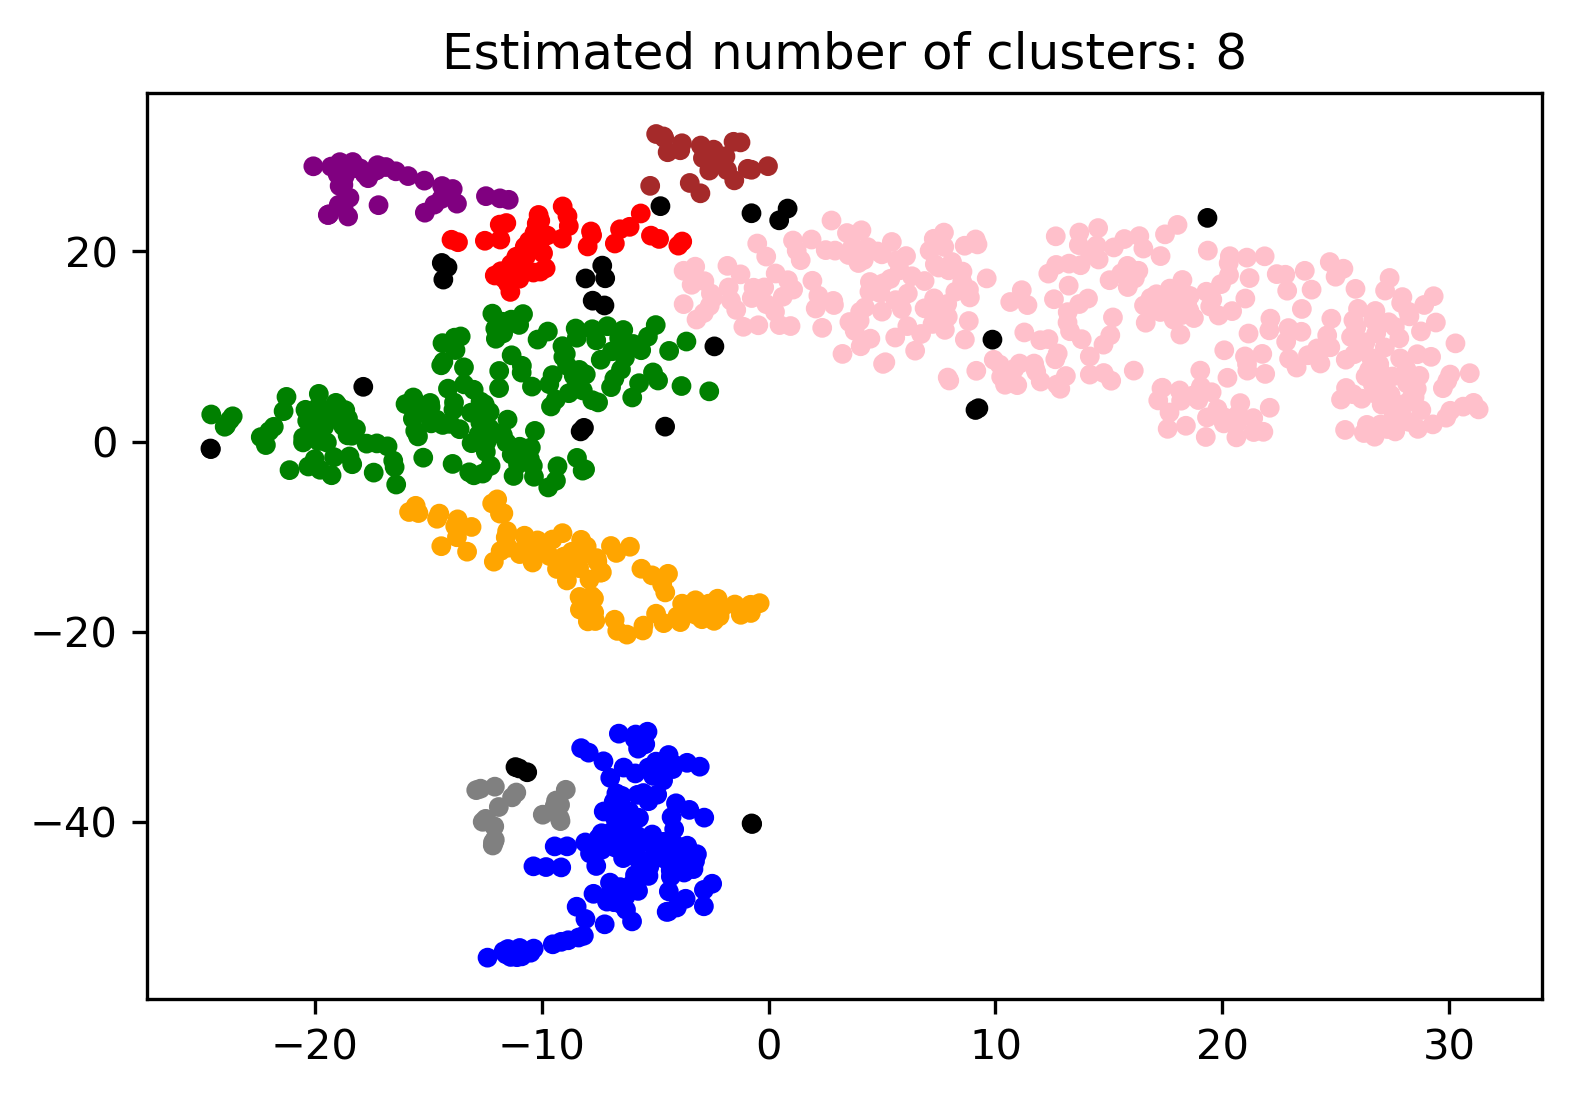

In [17]:
# Predicting the clusters
K=n_clusters
# Getting the cluster centers
color_c=['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','yellow']
#colores=paleta[0:K]
asignar=[]
for row in labels:
    if row==-1:
        asignar.append('black')
    else:
        asignar.append(color_c[row])

plt.scatter(X[:, 0], X[:, 1], c=asignar,s=14);
plt.title('Estimated number of clusters: %d' % n_clusters);

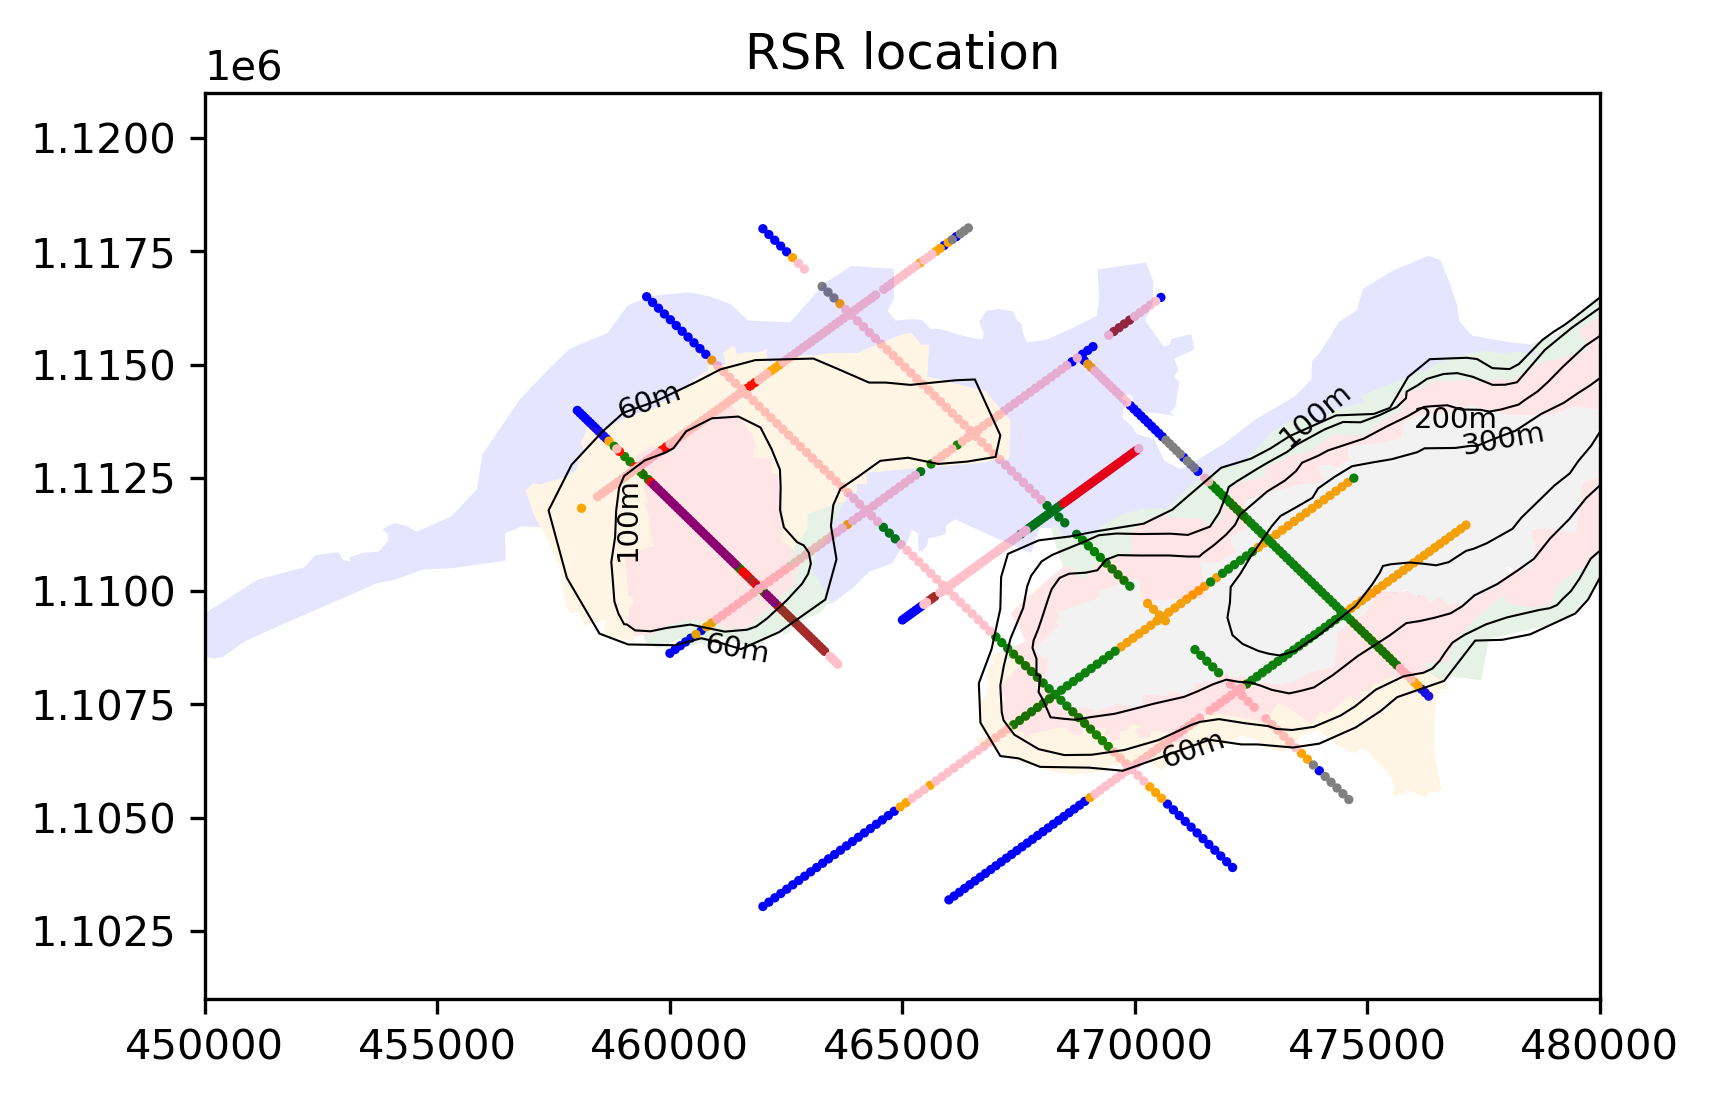

In [18]:
mapa_grupos(labels,'microzonas','RSR location',salida='grafico_mapa')

### Conclusions
We observe the different groups  of RSR are located in specific zones of the sedimentary basin (SB)
+ Blue group is located at the edge of SB
+ Orange gropup is located in the depest part of the SB
+ Green
+ Red in western sedimentary region
+ Purple
+ Brown in the area with depth between 60 to 100 m


In [24]:
matplotlib.rcParams['figure.dpi']=100

def plot_curve(clase,ylim, X):
    """
        Function for plotting the same group of the RSR curves
        clase: Group or class (0,...,N-1)
        ylim (limit of y coordinate)
        X array of the curves (RSR smoothed)
    """

    class_member_mask = (labels == clase)
    DG = X[class_member_mask & core_samples_mask]
    plt.plot(x,DG.transpose(),color=color_c[clase],linewidth=0.7)
    plt.xlabel('Frequency'); plt.ylabel('Amplitude');
    plt.title('Group No ' + str(clase+1))
    plt.ylim([0,ylim] ) 


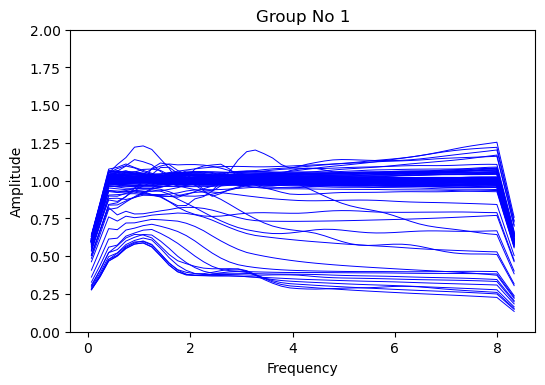

In [25]:
plot_curve(0,2,X_smooth)

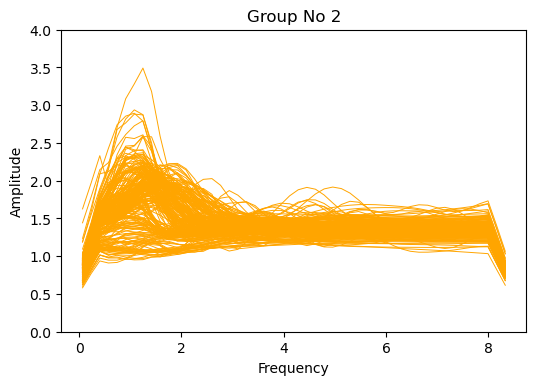

In [175]:
plot_curve(1,4, X_smooth)

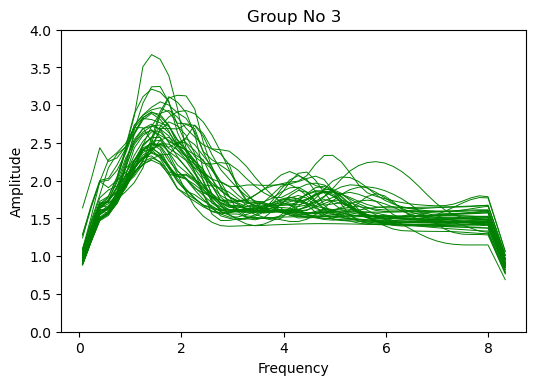

In [176]:
plot_curve(2,4,X_smooth)

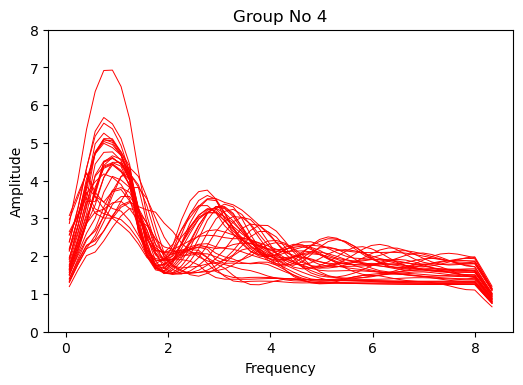

In [163]:
plot_curve(3,8,X_smooth)

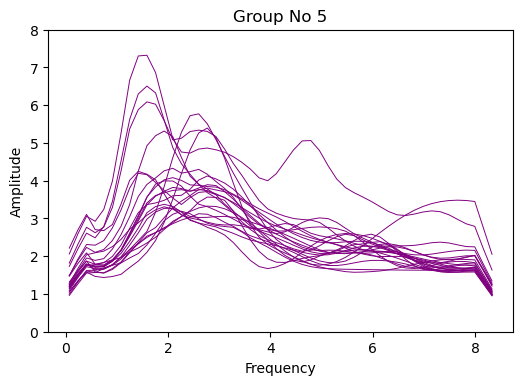

In [177]:
plot_curve(4,8,X_smooth)

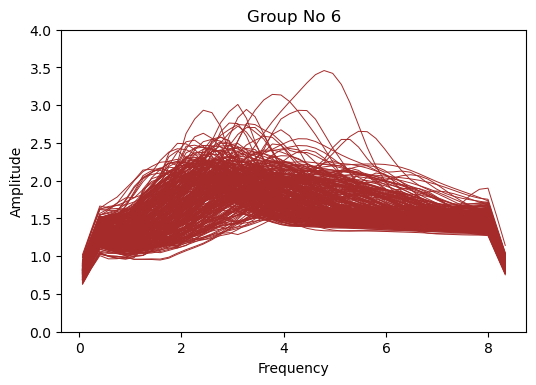

In [178]:
plot_curve(5,4,X_smooth)